## **RNN**

In [ ]:
# Install datasets if needed
!pip install datasets --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter

# 1. Load IMDB dataset with HuggingFace datasets
dataset = load_dataset('imdb')

# 2. Simple tokenizer and vocabulary builder (basic whitespace tokenizer)
def tokenize(text):
    return text.lower().split()

def build_vocab(dataset, min_freq=2):
    counter = Counter()
    for example in dataset:
        counter.update(tokenize(example['text']))
    # Keep tokens with min freq >= min_freq
    vocab = {word for word, freq in counter.items() if freq >= min_freq}
    # Add special tokens
    vocab = ['<pad>', '<unk>'] + sorted(vocab)
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx

# Build vocab from train split
word2idx = build_vocab(dataset['train'])

# 3. Encode text into list of token ids
def encode(text):
    tokens = tokenize(text)
    return [word2idx.get(token, word2idx['<unk>']) for token in tokens]

# 4. Dataset class for PyTorch
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.data = dataset[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_ids = encode(self.data[idx]['text'])
        label = self.data[idx]['label']
        return torch.tensor(text_ids, dtype=torch.long), label

# 5. Collate fn for padding batches
def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    texts_padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=word2idx['<pad>'])
    labels = torch.tensor(labels)
    return texts_padded, labels, lengths

# 6. Create dataloaders
batch_size = 64
train_dataset = IMDBDataset('train')
test_dataset = IMDBDataset('test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# 7. Define RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_emb = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed_emb)
        out = self.fc(hidden.squeeze(0))
        return out

# 8. Setup model and training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(word2idx)
embed_dim = 64
hidden_dim = 128
output_dim = 2
pad_idx = word2idx['<pad>']

model = RNNClassifier(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 9. Training loop
def train_epoch():
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for texts, labels, lengths in train_loader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * texts.size(0)
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += texts.size(0)

    return total_loss / total_samples, total_correct / total_samples

# 10. Evaluation loop
def evaluate():
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for texts, labels, lengths in test_loader:
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * texts.size(0)
            preds = outputs.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_samples += texts.size(0)

    return total_loss / total_samples, total_correct / total_samples

# 11. Run training for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = evaluate()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.6895 | Train Acc: 0.5416 | Val Loss: 0.7014 | Val Acc: 0.5135
Epoch 2 | Train Loss: 0.6788 | Train Acc: 0.5614 | Val Loss: 0.6759 | Val Acc: 0.5624
Epoch 3 | Train Loss: 0.6482 | Train Acc: 0.6084 | Val Loss: 0.6685 | Val Acc: 0.5797
Epoch 4 | Train Loss: 0.6111 | Train Acc: 0.6494 | Val Loss: 0.6619 | Val Acc: 0.6020
Epoch 5 | Train Loss: 0.5648 | Train Acc: 0.6990 | Val Loss: 0.6381 | Val Acc: 0.6383
Epoch 6 | Train Loss: 0.5097 | Train Acc: 0.7450 | Val Loss: 0.6577 | Val Acc: 0.6595
Epoch 7 | Train Loss: 0.4540 | Train Acc: 0.7866 | Val Loss: 0.6276 | Val Acc: 0.6827
Epoch 8 | Train Loss: 0.3974 | Train Acc: 0.8252 | Val Loss: 0.6354 | Val Acc: 0.6966
Epoch 9 | Train Loss: 0.3680 | Train Acc: 0.8410 | Val Loss: 0.6591 | Val Acc: 0.5738
Epoch 10 | Train Loss: 0.4040 | Train Acc: 0.8181 | Val Loss: 0.7398 | Val Acc: 0.6899


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

def get_all_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get preds and labels on test set
y_pred, y_true = get_all_preds_and_labels(model, test_loader)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro and per-class)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}\n")

print("Per-class Precision:", precision_per_class)
print("Per-class Recall:", recall_per_class)
print("Per-class F1:", f1_per_class)

print("\nConfusion Matrix:")
print(conf_mat)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['neg', 'pos']))


Accuracy: 0.6899
Macro Precision: 0.6975
Macro Recall: 0.6899
Macro F1 Score: 0.6869

Per-class Precision: [0.73623967 0.65873069]
Per-class Recall: [0.59176 0.788  ]
Per-class F1: [0.65614051 0.71759006]

Confusion Matrix:
[[7397 5103]
 [2650 9850]]

Classification Report:
              precision    recall  f1-score   support

         neg       0.74      0.59      0.66     12500
         pos       0.66      0.79      0.72     12500

    accuracy                           0.69     25000
   macro avg       0.70      0.69      0.69     25000
weighted avg       0.70      0.69      0.69     25000



In [ ]:
!pip install matplotlib --quiet


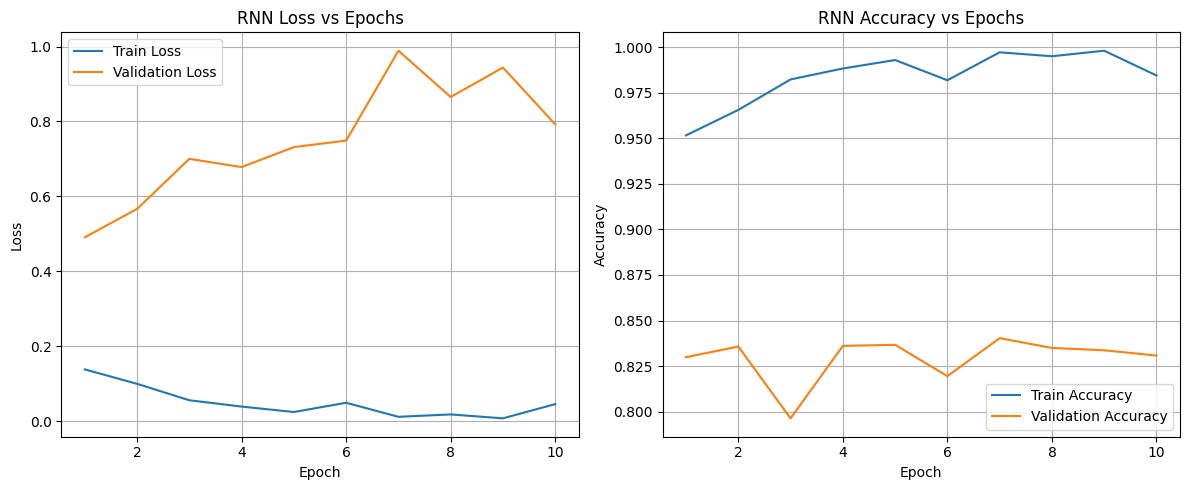

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **LSTM**

In [ ]:
import torch.nn as nn

# 7. Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True) # Use nn.LSTM
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_emb = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, cell) = self.lstm(packed_emb)
        out = self.fc(hidden.squeeze(0))
        return out

In [ ]:
from datasets import load_dataset

# 1. Load IMDB dataset with HuggingFace datasets
dataset = load_dataset('imdb')

# 2. Simple tokenizer and vocabulary builder (basic whitespace tokenizer)
def tokenize(text):
    return text.lower().split()

def build_vocab(dataset, min_freq=2):
    counter = Counter()
    for example in dataset:
        counter.update(tokenize(example['text']))
    # Keep tokens with min freq >= min_freq
    vocab = {word for word, freq in counter.items() if freq >= min_freq}
    # Add special tokens
    vocab = ['<pad>', '<unk>'] + sorted(vocab)
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx

# Build vocab from train split
word2idx = build_vocab(dataset['train'])

# Re-define variables that depend on word2idx
vocab_size = len(word2idx)
pad_idx = word2idx['<pad>']

# Re-define other variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64
hidden_dim = 128
output_dim = 2

# 8. Setup LSTM model and training
lstm_model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx).to(device)
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

print("LSTM model initialized and moved to device.")
print("Loss function and optimizer defined.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

LSTM model initialized and moved to device.
Loss function and optimizer defined.


In [ ]:
# 9. Training loop for LSTM
def train_lstm_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for texts, labels, lengths in dataloader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * texts.size(0)
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += texts.size(0)

    return total_loss / total_samples, total_correct / total_samples

In [ ]:
# 10. Evaluation loop for LSTM
def evaluate_lstm(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * texts.size(0)
            preds = outputs.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_samples += texts.size(0)

    return total_loss / total_samples, total_correct / total_samples

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn

# 2. Simple tokenizer and vocabulary builder (basic whitespace tokenizer)
def tokenize(text):
    return text.lower().split()

# 3. Encode text into list of token ids
def encode(text):
    tokens = tokenize(text)
    # word2idx is available from previous cells
    return [word2idx.get(token, word2idx['<unk>']) for token in tokens]


# 4. Dataset class for PyTorch
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        # Access the already loaded dataset
        self.data = dataset[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_ids = encode(self.data[idx]['text'])
        label = self.data[idx]['label']
        return torch.tensor(text_ids, dtype=torch.long), label

# 5. Collate fn for padding batches
def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    # Use the existing word2idx for padding value
    texts_padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=word2idx['<pad>'])
    labels = torch.tensor(labels)
    return texts_padded, labels, lengths

# 6. Create dataloaders
batch_size = 64
train_dataset = IMDBDataset('train')
test_dataset = IMDBDataset('test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the number of training epochs
num_lstm_epochs = 10

# Loop through the specified number of epochs
for epoch in range(num_lstm_epochs):
    # Train for one epoch
    train_loss, train_acc = train_lstm_epoch(lstm_model, train_loader, lstm_criterion, lstm_optimizer)
    # Append training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_loss, val_acc = evaluate_lstm(lstm_model, test_loader, lstm_criterion)
    # Append validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print epoch progress
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.1378 | Train Acc: 0.9516 | Val Loss: 0.4905 | Val Acc: 0.8299
Epoch 2 | Train Loss: 0.0993 | Train Acc: 0.9656 | Val Loss: 0.5663 | Val Acc: 0.8357
Epoch 3 | Train Loss: 0.0554 | Train Acc: 0.9823 | Val Loss: 0.7001 | Val Acc: 0.7963
Epoch 4 | Train Loss: 0.0386 | Train Acc: 0.9883 | Val Loss: 0.6781 | Val Acc: 0.8361
Epoch 5 | Train Loss: 0.0240 | Train Acc: 0.9930 | Val Loss: 0.7314 | Val Acc: 0.8367
Epoch 6 | Train Loss: 0.0488 | Train Acc: 0.9819 | Val Loss: 0.7488 | Val Acc: 0.8195
Epoch 7 | Train Loss: 0.0112 | Train Acc: 0.9972 | Val Loss: 0.9888 | Val Acc: 0.8403
Epoch 8 | Train Loss: 0.0176 | Train Acc: 0.9950 | Val Loss: 0.8653 | Val Acc: 0.8350
Epoch 9 | Train Loss: 0.0072 | Train Acc: 0.9981 | Val Loss: 0.9439 | Val Acc: 0.8337
Epoch 10 | Train Loss: 0.0452 | Train Acc: 0.9845 | Val Loss: 0.7922 | Val Acc: 0.8308


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

def get_all_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            # Ensure tensors are on the correct device
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


# Ensure the model is on the correct device
lstm_model.to(device)

# Get preds and labels on test set
y_pred_lstm, y_true_lstm = get_all_preds_and_labels(lstm_model, test_loader)


print("Classification Report for LSTM Model:")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=['neg', 'pos']))

Classification Report for LSTM Model:
              precision    recall  f1-score   support

         neg       0.85      0.78      0.82     12500
         pos       0.80      0.87      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



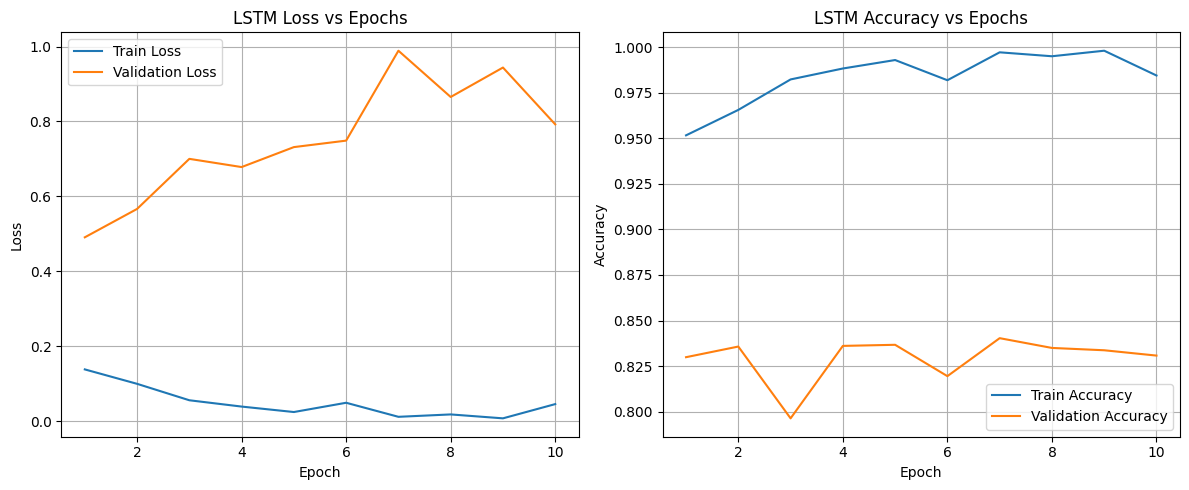

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_lstm_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_lstm_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_lstm_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_lstm_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()